<a href="https://colab.research.google.com/github/ShriramGithub7/EVA8-Assignment-4/blob/main/EVA8_Session_4_Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target, Results, Analysis

Target:

  - Create basic setup
  - Setup transforms, data loader and basic working code

Results:
  - Parameters: 2.7M
  - Best training Accuracy: 99.92%
  - Best Test Accuracy: 99.29%

Analysis:
  - Model is working and able to achieve good accuracy but not 99.40%
  - Model is quite heavy
  - Model is overfitting

# Import libraries

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function


# Find mean and std deviation of the data

In [ ]:
testing_transofrms = transforms.Compose([transforms.ToTensor()])
exp= datasets.MNIST('.data/', train=True, download=True, transform=testing_transofrms)
exp_data = exp.train_data
exp_data=exp.transform(exp_data.numpy())


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
print('shape - ', exp_data.shape)
print('size - ', exp_data.size())
print('min - ', exp_data.min())
print('max - ', exp_data.max())
print('mean - ', exp_data.mean())
print('std - ', exp_data.std())
print('var - ', exp_data.var())

shape -  torch.Size([28, 60000, 28])
size -  torch.Size([28, 60000, 28])
min -  tensor(0.)
max -  tensor(1.)
mean -  tensor(0.1307)
std -  tensor(0.3081)
var -  tensor(0.0949)


# Data transformation

In [ ]:
#training data transormation

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307), (0.3081))])

#testing data transformation
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307), (0.3081))])

# Load data, split it in train/test and apply transform 

In [ ]:
train = datasets.MNIST('.data/', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('.data/', train=False, download = True, transform=test_transforms)

# Dataloader arguments and Train/Test Dataloaders

In [ ]:
from torch.utils.data import dataloader
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available - ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader=torch.utils.data.DataLoader(train, **dataloader_args)

test_loader=torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available -  True


# View few images

torch.Size([128, 1, 28, 28])
torch.Size([128])


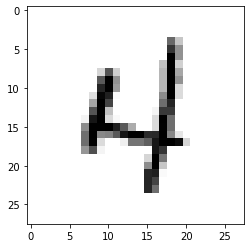

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')


torch.Size([128, 1, 28, 28])
torch.Size([128])


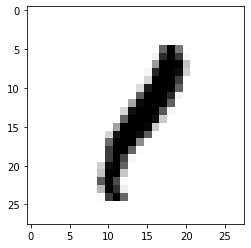

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

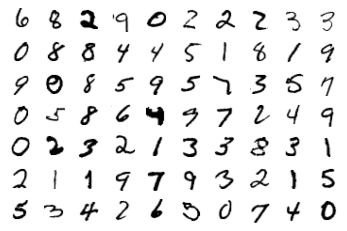

In [ ]:
figure = plt.figure()
num_of_images=70
for index in range (1, num_of_images+1):
  plt.subplot(7, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')



# Build the model

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.container import Sequential
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=0) # 28>26
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 26 > 26
        self.pool1 = nn.MaxPool2d(2, 2) # 26 > 13
        self.conv3 = nn.Conv2d(64, 128, 3, padding=0) # 13> 11
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #11 > 11
        self.pool2 = nn.MaxPool2d(2, 2) # 11 > 5
        self.conv5 = nn.Conv2d(256, 512, 3) # 5 > 3
        self.conv6 = nn.Conv2d(512, 256, 3, padding=1) # 5 > 5
        self.conv7 = nn.Conv2d(256, 10, 3) # 5 > 3

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 26, 26]          18,496
         MaxPool2d-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
            Conv2d-5          [-1, 256, 11, 11]         295,168
         MaxPool2d-6            [-1, 256, 5, 5]               0
            Conv2d-7            [-1, 512, 3, 3]       1,180,160
            Conv2d-8            [-1, 256, 3, 3]       1,179,904
            Conv2d-9             [-1, 10, 1, 1]          23,050
Total params: 2,770,954
Trainable params: 2,770,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.03
Params size (MB): 10.57
Estimated Total Size (MB): 11.61
-------------------------------------

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train the model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.20620961487293243 Batch_id=468 Accuracy=84.00: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]



Test set: Average loss: 0.0665, Accuracy: 9777/10000 (97.77%)

EPOCH: 1


Loss=0.04863473400473595 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0391, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.013047699816524982 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]



Test set: Average loss: 0.0361, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.03465611860156059 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]



Test set: Average loss: 0.0304, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.09655245393514633 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]



Test set: Average loss: 0.0312, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.05029207468032837 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]



Test set: Average loss: 0.0292, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.0008080443367362022 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]



Test set: Average loss: 0.0306, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.0470472015440464 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]



Test set: Average loss: 0.0274, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.006680451333522797 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]



Test set: Average loss: 0.0356, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.0033837389200925827 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]



Test set: Average loss: 0.0362, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.0038775841239839792 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]



Test set: Average loss: 0.0290, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.00013269345799926668 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]



Test set: Average loss: 0.0291, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.00017571182979736477 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]



Test set: Average loss: 0.0339, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.005785826593637466 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]



Test set: Average loss: 0.0336, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.0009352688794024289 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]



Test set: Average loss: 0.0342, Accuracy: 9916/10000 (99.16%)

